# Getting LIGO data

This notebook demonstrates how to obtain LIGO data in bulk. We can split it up into shorter segements for training a noise model, as in the other example for 1h data. The difference will be that we have to handle several HDF5 files from GWOSC.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm 
from glob import glob

import os
import wget
from gwosc.timeline import get_segments
from gwosc.locate import get_urls

import requests

## Downloading the data

GW data are made publicly available through the Gravitational-Wave Open Science Center ([GWOSC](https://gw-openscience.org)), both in bulk and for shorter period surrounding confirmed detections.

The easiest way to access GW data in bulk would be through the [GWpy package](https://gwpy.github.io/docs/stable/timeseries/io/#automatic-discovery-of-gw-detector-data), specifically the [`TimeSeries.fetch_open_data()`](https://gwpy.github.io/docs/stable/timeseries/opendata/) functionality. However,  to be more transparent about where the data are stored, we will download the files from GWOSC directly. GWpy does something similar to the operations below under the hood.

### GW150914

We will attempt to download around 2 months of data after the first detection ([GW150914](https://en.wikipedia.org/wiki/First_observation_of_gravitational_waves)). We will download $4kHz$ data to make things faster---but we should think about whether we want to go all the way up to $16kHz$ (which is also available).

For the first detection, only the two LIGO detectors, Hanford (H1) and Livingston (L1), were available (the European detector, Virgo, wasn't operating yet). The GWOSC page for this event is [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3).

The first thing we need to do is define the GPS times for the period of time we are interested in. Note that the GW150914 event happened at GPS time $t_0 = 1126259462.4 s$. Let's try to get data over $[t_0 - 12\, {\rm h}, t_0 + 2\, {\rm months}]$ around that.

In [9]:
t0 = 1126259462

bulk_start_time = t0 - 12*60*60
bulk_end_time = t0 + 60*60*24*30*2

In [10]:
bulk_start_time, bulk_end_time

(1126216262, 1126432262)

Now we need is to get the URLs for the available files in the GWOSC server. Luckily, we can do this easily with the [gwosc](https://gwosc.readthedocs.io/en/latest/index.html) package.

In [11]:
# define the instrument we want ('H1' for Hanford, 'L1' for Livingston)
ifo = 'H1'

# get time segments of available data within the specified 'bulk' time
segments = get_segments(f'{ifo}_DATA', bulk_start_time, bulk_end_time)

# get URLs of data files for the above segments
urls = get_urls(ifo, segments[0][0], segments[-1][-1], sample_rate=4096)
urls

ConnectTimeout: HTTPSConnectionPool(host='gwosc.org', port=443): Max retries exceeded with url: /archive/0/99999999999/json/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x14f2ee90e610>, 'Connection to gwosc.org timed out. (connect timeout=None)'))

Now that we have the URLs of all the available data in the specified time, let's download the files!
**WARNING: this might take a while!**

In [7]:
# define directory into which to download data files
data_dir = 'bulk_data'
os.makedirs(data_dir, exist_ok=True)

# decide whether to download a file that already exists
force = False

for url in tqdm(urls):
    fname = os.path.basename(url)
    file_path = os.path.join(data_dir, fname)
    if not os.path.exists(file_path) or force:
        wget.download(url, file_path)

  0%|          | 0/2 [00:00<?, ?it/s]

### Read in the data

You can read into a `pandas.Series`  the data using the following function. (There's no need to use `pandas`---this is just for convenience.)

In [8]:
def read_data(path, **kws):
    with h5py.File(path, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
        dt = T/len(h)
        time = t0 + dt*np.arange(len(h))
        return pd.Series(h, index=time, **kws)

In [9]:
data_list = []
for path in tqdm(sorted(glob(os.path.join(data_dir, '*.hdf5')))):
    data_list.append(read_data(path))

  0%|          | 0/2 [00:00<?, ?it/s]

Each of the segments we just loaded should in principle span $1h$ of data. However, _there will be gaps!_ We can see this by plotting this first segment we loaded:

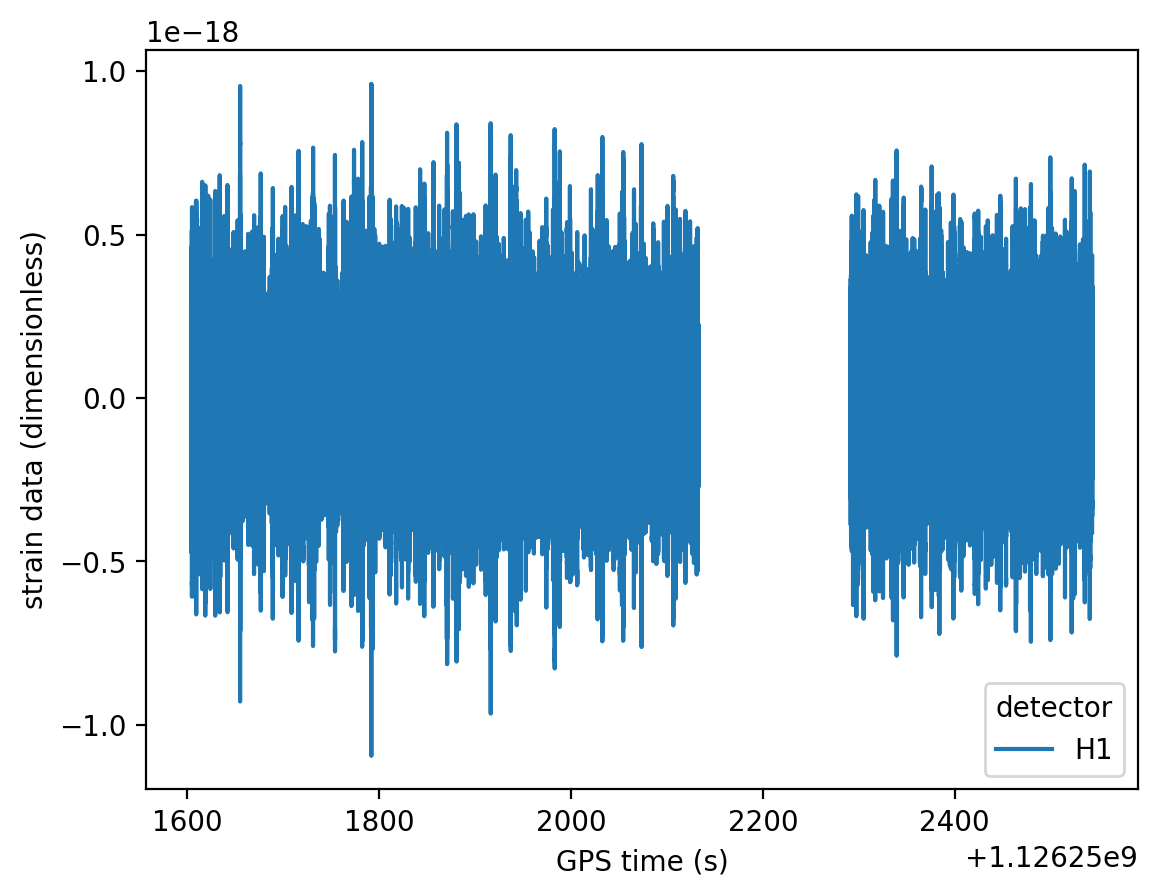

In [10]:
d = data_list[0]
epoch = d.index[0]
plt.plot(d, label=ifo)
plt.legend(title="detector", loc="lower right")
plt.xlabel("GPS time (s)")
plt.ylabel("strain data (dimensionless)");

The data are padded with `NaN`'s:

In [11]:
d

1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
                    ...     
1.126253e+09   -1.962237e-20
1.126253e+09   -1.357275e-20
1.126253e+09   -2.460189e-20
1.126253e+09   -6.847398e-20
1.126253e+09   -2.896389e-20
Length: 16777216, dtype: float64

Below, we will throw away segments containing `Nan`'s. Although we should think about whether this biases us (e.g., periods with missing data could be preceeded by loud glitches).

### Split into segments

Splitting the data into $4s$ is quite trivial. In doing so, we will lose the distinction between different files.

In [12]:
# duration of segment in seconds
T = 4

data_segments = []
for d in tqdm(data_list):
    # sampling interval
    dt = d.index[1] - d.index[0]
    # segment length
    N = int(round(T / dt))
    # number of segments
    N_segments = int(len(d) / N)
    data_segments += [d.iloc[k*N:k*N+N] for k in range(N_segments)]

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
print(f"There are {len(data_segments)} {ifo} segments.")

There are 2048 H1 segments.


In this case, we know there is a true signal at GPS time $t = 1126259462.4 s$ so make sure to throw away that segment---but, in addition, since we are getting a long span of time, we should check that there aren't any _other_ GW events in these data. Also, there will be segments containing `NaN`'s, so throw those away too.

Before proceeeding, download a list of events from GWOSC, and get their respective times.

In [17]:
# get detection catalog from GWOSC
url = 'https://www.gw-openscience.org/eventapi/jsonfull/GWTC/'
with requests.get(url) as r:
    rjson = r.json()

true_event_times = sorted([v['GPS'] for v in rjson['events'].values()])

In [34]:
good_segments = []
for s in tqdm(data_segments):
    no_events = all([(t0 < s.index[0] or t0 > s.index[-1]) for t0 in true_event_times])
    no_nans = not s.isnull().values.any()
    if no_events and no_nans:
        good_segments.append(s)

print(f"There are {len(good_segments)} good {ifo} segments.")

  0%|          | 0/2048 [00:00<?, ?it/s]

There are 1219 good H1 segments.
